# **What about the minimum dataset for obtaining a satisfying fidelity?**

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation


In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [6]:
sim_bknd=Aer.get_backend('aer_simulator')

In [7]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## (In)Fidelity Implementation

In [8]:
def density_matrix_from_bloch_vector(bloch_vector):
   rho = 0.5 * (I+ bloch_vector[0]*X + bloch_vector[1]*Y + bloch_vector[2]*Z)
   return rho

In [9]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

In [10]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [11]:
A = tf.stack([X_tf,Y_tf,Z_tf]) 

In [12]:
@tf.function
def infidelity1(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   infidelity = 1 - fidelity
   return infidelity 

## Noise Models 


In [13]:
#SINGLE ELEMENT OF THE OPERATOR-SUM REPRESENTATION

def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [14]:
#BIT FLIP, PHASE FLIP AND BIT-PHASE FLIP ERROR

def flip_error(num_qubits, rho, error_type, p):

    E_0 = np.sqrt(1-p)*I
    if error_type == 'bit':
        E_1 = np.sqrt(p)*X
    if error_type == 'phase':
        E_1 = np.sqrt(p)*Z
    if error_type == 'bp':
        E_1 = np.sqrt(p)*Y
        
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Training the Algorithm

In [15]:
# Generate data
data = generate_Haar_data(1, 100) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [16]:
bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]
#APPLY ERROR (in this case phase error with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

## <font color='red'>MSE - 10 samples</font>

In [17]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:10], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:10], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [18]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [19]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

In [20]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 862ms/step - loss: 0.3345 - val_loss: 0.2981
Epoch 2/200
1/1 [==============================] - 0s 43ms/step - loss: 0.3190 - val_loss: 0.2882
Epoch 3/200
1/1 [==============================] - 0s 50ms/step - loss: 0.3049 - val_loss: 0.2786
Epoch 4/200
1/1 [==============================] - 0s 48ms/step - loss: 0.2916 - val_loss: 0.2694
Epoch 5/200
1/1 [==============================] - 0s 46ms/step - loss: 0.2787 - val_loss: 0.2606
Epoch 6/200
1/1 [==============================] - 0s 55ms/step - loss: 0.2664 - val_loss: 0.2521
Epoch 7/200
1/1 [==============================] - 0s 47ms/step - loss: 0.2547 - val_loss: 0.2439
Epoch 8/200
1/1 [==============================] - 0s 45ms/step - loss: 0.2435 - val_loss: 0.2360
Epoch 9/200
1/1 [==============================] - 0s 45ms/step - loss: 0.2328 - val_loss: 0.2283
Epoch 10/200
1/1 [==============================] - 0s 45ms/step - loss: 0.2223 - val_loss: 0.2209
Epoch 11/200
1/1 [

1/1 [==============================] - 0s 42ms/step - loss: 6.7605e-04 - val_loss: 0.0080
Epoch 84/200
1/1 [==============================] - 0s 40ms/step - loss: 6.2145e-04 - val_loss: 0.0079
Epoch 85/200
1/1 [==============================] - 0s 50ms/step - loss: 5.7008e-04 - val_loss: 0.0078
Epoch 86/200
1/1 [==============================] - 0s 43ms/step - loss: 5.2213e-04 - val_loss: 0.0077
Epoch 87/200
1/1 [==============================] - 0s 40ms/step - loss: 4.7757e-04 - val_loss: 0.0077
Epoch 88/200
1/1 [==============================] - 0s 44ms/step - loss: 4.3630e-04 - val_loss: 0.0076
Epoch 89/200
1/1 [==============================] - 0s 42ms/step - loss: 3.9813e-04 - val_loss: 0.0076
Epoch 90/200
1/1 [==============================] - 0s 43ms/step - loss: 3.6283e-04 - val_loss: 0.0076
Epoch 91/200
1/1 [==============================] - 0s 40ms/step - loss: 3.3072e-04 - val_loss: 0.0075
Epoch 92/200
1/1 [==============================] - 0s 41ms/step - loss: 3.0137e-04 - 

1/1 [==============================] - 0s 42ms/step - loss: 1.3600e-05 - val_loss: 0.0067
Epoch 163/200
1/1 [==============================] - 0s 42ms/step - loss: 1.3113e-05 - val_loss: 0.0067
Epoch 164/200
1/1 [==============================] - 0s 41ms/step - loss: 1.2629e-05 - val_loss: 0.0067
Epoch 165/200
1/1 [==============================] - 0s 40ms/step - loss: 1.2161e-05 - val_loss: 0.0067
Epoch 166/200
1/1 [==============================] - 0s 45ms/step - loss: 1.1729e-05 - val_loss: 0.0066
Epoch 167/200
1/1 [==============================] - 0s 43ms/step - loss: 1.1332e-05 - val_loss: 0.0066
Epoch 168/200
1/1 [==============================] - 0s 40ms/step - loss: 1.0934e-05 - val_loss: 0.0066
Epoch 169/200
1/1 [==============================] - 0s 43ms/step - loss: 1.0532e-05 - val_loss: 0.0066
Epoch 170/200
1/1 [==============================] - 0s 40ms/step - loss: 1.0155e-05 - val_loss: 0.0066
Epoch 171/200
1/1 [==============================] - 0s 41ms/step - loss: 9.79

In [21]:
score = model.evaluate(x_test,  y_test, verbose=2)

1/1 - 0s - loss: 0.0076 - 106ms/epoch - 106ms/step


In [22]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  #infid=infidelity(y_test[i], y_prediction[i])
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)


fid10_c = tf.math.reduce_mean(fidelities)
fid10 = tf.cast(fid10_c, tf.float64)
print(fid10)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.944531480989105, shape=(), dtype=float64)


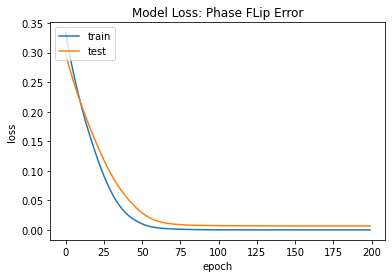

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 5 samples</font>

In [24]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:5], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:5], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [25]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [26]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

In [27]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 787ms/step - loss: 0.3526 - val_loss: 0.3446
Epoch 2/200
1/1 [==============================] - 0s 44ms/step - loss: 0.3373 - val_loss: 0.3397
Epoch 3/200
1/1 [==============================] - 0s 48ms/step - loss: 0.3230 - val_loss: 0.3350
Epoch 4/200
1/1 [==============================] - 0s 45ms/step - loss: 0.3098 - val_loss: 0.3302
Epoch 5/200
1/1 [==============================] - 0s 47ms/step - loss: 0.2969 - val_loss: 0.3255
Epoch 6/200
1/1 [==============================] - 0s 46ms/step - loss: 0.2846 - val_loss: 0.3209
Epoch 7/200
1/1 [==============================] - 0s 46ms/step - loss: 0.2727 - val_loss: 0.3164
Epoch 8/200
1/1 [==============================] - 0s 57ms/step - loss: 0.2614 - val_loss: 0.3119
Epoch 9/200
1/1 [==============================] - 0s 46ms/step - loss: 0.2508 - val_loss: 0.3075
Epoch 10/200
1/1 [==============================] - 0s 47ms/step - loss: 0.2409 - val_loss: 0.3030
Epoch 11/200
1/1 [

Epoch 84/200
1/1 [==============================] - 0s 39ms/step - loss: 0.0016 - val_loss: 0.1258
Epoch 85/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0016 - val_loss: 0.1256
Epoch 86/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0015 - val_loss: 0.1253
Epoch 87/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0015 - val_loss: 0.1250
Epoch 88/200
1/1 [==============================] - 0s 38ms/step - loss: 0.0014 - val_loss: 0.1247
Epoch 89/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0014 - val_loss: 0.1244
Epoch 90/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0014 - val_loss: 0.1240
Epoch 91/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0013 - val_loss: 0.1236
Epoch 92/200
1/1 [==============================] - 0s 45ms/step - loss: 0.0013 - val_loss: 0.1232
Epoch 93/200
1/1 [==============================] - 0s 38ms/step - loss: 0.0013 - val_loss: 0.1228
Epoch 94/2

1/1 [==============================] - 0s 44ms/step - loss: 1.9963e-04 - val_loss: 0.0983
Epoch 164/200
1/1 [==============================] - 0s 45ms/step - loss: 1.9215e-04 - val_loss: 0.0980
Epoch 165/200
1/1 [==============================] - 0s 41ms/step - loss: 1.8478e-04 - val_loss: 0.0977
Epoch 166/200
1/1 [==============================] - 0s 44ms/step - loss: 1.7758e-04 - val_loss: 0.0975
Epoch 167/200
1/1 [==============================] - 0s 40ms/step - loss: 1.7086e-04 - val_loss: 0.0972
Epoch 168/200
1/1 [==============================] - 0s 38ms/step - loss: 1.6418e-04 - val_loss: 0.0970
Epoch 169/200
1/1 [==============================] - 0s 40ms/step - loss: 1.5745e-04 - val_loss: 0.0967
Epoch 170/200
1/1 [==============================] - 0s 39ms/step - loss: 1.5115e-04 - val_loss: 0.0964
Epoch 171/200
1/1 [==============================] - 0s 41ms/step - loss: 1.4518e-04 - val_loss: 0.0962
Epoch 172/200
1/1 [==============================] - 0s 40ms/step - loss: 1.39

In [28]:
score = model.evaluate(x_test,  y_test, verbose=2)

1/1 - 0s - loss: 0.0837 - 101ms/epoch - 101ms/step


In [29]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  #infid=infidelity(y_test[i], y_prediction[i])
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

fid5_c = tf.math.reduce_mean(fidelities)
fid5 = tf.cast(fid5_c, tf.float64)

print(fid5)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.8028045835020914, shape=(), dtype=float64)


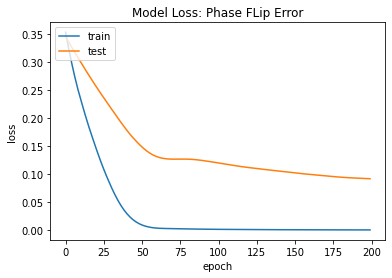

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 20 samples</font>

In [31]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:20], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:20], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [32]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [33]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

In [34]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 155ms/step - loss: 0.3683 - val_loss: 0.3473
Epoch 2/200
2/2 [==============================] - 0s 44ms/step - loss: 0.3448 - val_loss: 0.3283
Epoch 3/200
2/2 [==============================] - 0s 40ms/step - loss: 0.3240 - val_loss: 0.3099
Epoch 4/200
2/2 [==============================] - 0s 47ms/step - loss: 0.3047 - val_loss: 0.2920
Epoch 5/200
2/2 [==============================] - 0s 46ms/step - loss: 0.2865 - val_loss: 0.2751
Epoch 6/200
2/2 [==============================] - 0s 41ms/step - loss: 0.2690 - val_loss: 0.2593
Epoch 7/200
2/2 [==============================] - 0s 43ms/step - loss: 0.2529 - val_loss: 0.2440
Epoch 8/200
2/2 [==============================] - 0s 48ms/step - loss: 0.2378 - val_loss: 0.2290
Epoch 9/200
2/2 [==============================] - 0s 44ms/step - loss: 0.2232 - val_loss: 0.2143
Epoch 10/200
2/2 [==============================] - 0s 44ms/step - loss: 0.2091 - val_loss: 0.2002
Epoch 11/200
2/2 [

2/2 [==============================] - 0s 38ms/step - loss: 1.7513e-04 - val_loss: 0.0019
Epoch 83/200
2/2 [==============================] - 0s 41ms/step - loss: 1.6971e-04 - val_loss: 0.0019
Epoch 84/200
2/2 [==============================] - 0s 40ms/step - loss: 1.6448e-04 - val_loss: 0.0019
Epoch 85/200
2/2 [==============================] - 0s 39ms/step - loss: 1.5981e-04 - val_loss: 0.0018
Epoch 86/200
2/2 [==============================] - 0s 39ms/step - loss: 1.5393e-04 - val_loss: 0.0018
Epoch 87/200
2/2 [==============================] - 0s 39ms/step - loss: 1.5050e-04 - val_loss: 0.0018
Epoch 88/200
2/2 [==============================] - 0s 41ms/step - loss: 1.4538e-04 - val_loss: 0.0018
Epoch 89/200
2/2 [==============================] - 0s 38ms/step - loss: 1.4060e-04 - val_loss: 0.0018
Epoch 90/200
2/2 [==============================] - 0s 36ms/step - loss: 1.3614e-04 - val_loss: 0.0018
Epoch 91/200
2/2 [==============================] - 0s 42ms/step - loss: 1.3167e-04 - 

2/2 [==============================] - 0s 39ms/step - loss: 2.5763e-05 - val_loss: 0.0014
Epoch 162/200
2/2 [==============================] - 0s 45ms/step - loss: 2.4714e-05 - val_loss: 0.0014
Epoch 163/200
2/2 [==============================] - 0s 39ms/step - loss: 2.4172e-05 - val_loss: 0.0014
Epoch 164/200
2/2 [==============================] - 0s 39ms/step - loss: 2.3838e-05 - val_loss: 0.0014
Epoch 165/200
2/2 [==============================] - 0s 39ms/step - loss: 2.3291e-05 - val_loss: 0.0014
Epoch 166/200
2/2 [==============================] - 0s 41ms/step - loss: 2.2812e-05 - val_loss: 0.0014
Epoch 167/200
2/2 [==============================] - 0s 37ms/step - loss: 2.2360e-05 - val_loss: 0.0014
Epoch 168/200
2/2 [==============================] - 0s 41ms/step - loss: 2.1866e-05 - val_loss: 0.0014
Epoch 169/200
2/2 [==============================] - 0s 39ms/step - loss: 2.1546e-05 - val_loss: 0.0014
Epoch 170/200
2/2 [==============================] - 0s 37ms/step - loss: 2.07

In [35]:
score = model.evaluate(x_test,  y_test, verbose=2)

1/1 - 0s - loss: 8.2417e-04 - 99ms/epoch - 99ms/step


In [36]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  #infid=infidelity(y_test[i], y_prediction[i])
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

fid20_c = tf.math.reduce_mean(fidelities)
fid20 = tf.cast(fid20_c, tf.float64)

print(fid20)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.993061532526419, shape=(), dtype=float64)


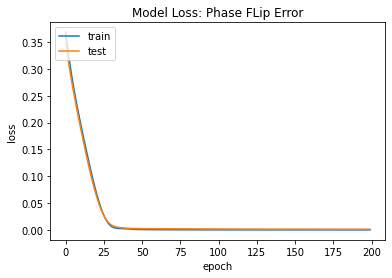

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 30 samples</font>

In [38]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:30], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:30], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [39]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [40]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

In [41]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
3/3 [==============================] - 1s 79ms/step - loss: 0.3360 - val_loss: 0.2958
Epoch 2/200
3/3 [==============================] - 0s 23ms/step - loss: 0.3047 - val_loss: 0.2668
Epoch 3/200
3/3 [==============================] - 0s 21ms/step - loss: 0.2767 - val_loss: 0.2406
Epoch 4/200
3/3 [==============================] - 0s 20ms/step - loss: 0.2505 - val_loss: 0.2167
Epoch 5/200
3/3 [==============================] - 0s 22ms/step - loss: 0.2273 - val_loss: 0.1948
Epoch 6/200
3/3 [==============================] - 0s 21ms/step - loss: 0.2049 - val_loss: 0.1742
Epoch 7/200
3/3 [==============================] - 0s 22ms/step - loss: 0.1838 - val_loss: 0.1552
Epoch 8/200
3/3 [==============================] - 0s 22ms/step - loss: 0.1638 - val_loss: 0.1373
Epoch 9/200
3/3 [==============================] - 0s 22ms/step - loss: 0.1446 - val_loss: 0.1205
Epoch 10/200
3/3 [==============================] - 0s 23ms/step - loss: 0.1266 - val_loss: 0.1049
Epoch 11/200
3/3 [=

3/3 [==============================] - 0s 21ms/step - loss: 1.4437e-04 - val_loss: 8.9055e-04
Epoch 82/200
3/3 [==============================] - 0s 20ms/step - loss: 1.3998e-04 - val_loss: 8.8291e-04
Epoch 83/200
3/3 [==============================] - 0s 21ms/step - loss: 1.3503e-04 - val_loss: 8.7408e-04
Epoch 84/200
3/3 [==============================] - 0s 21ms/step - loss: 1.3036e-04 - val_loss: 8.6762e-04
Epoch 85/200
3/3 [==============================] - 0s 23ms/step - loss: 1.2557e-04 - val_loss: 8.6349e-04
Epoch 86/200
3/3 [==============================] - 0s 21ms/step - loss: 1.2335e-04 - val_loss: 8.5577e-04
Epoch 87/200
3/3 [==============================] - 0s 20ms/step - loss: 1.1764e-04 - val_loss: 8.4607e-04
Epoch 88/200
3/3 [==============================] - 0s 19ms/step - loss: 1.1486e-04 - val_loss: 8.3624e-04
Epoch 89/200
3/3 [==============================] - 0s 19ms/step - loss: 1.1073e-04 - val_loss: 8.2772e-04
Epoch 90/200
3/3 [==============================] 

3/3 [==============================] - 0s 22ms/step - loss: 1.9746e-05 - val_loss: 6.2190e-04
Epoch 158/200
3/3 [==============================] - 0s 21ms/step - loss: 1.9794e-05 - val_loss: 6.1919e-04
Epoch 159/200
3/3 [==============================] - 0s 19ms/step - loss: 1.9613e-05 - val_loss: 6.1682e-04
Epoch 160/200
3/3 [==============================] - 0s 19ms/step - loss: 1.8943e-05 - val_loss: 6.1786e-04
Epoch 161/200
3/3 [==============================] - 0s 21ms/step - loss: 1.8485e-05 - val_loss: 6.1934e-04
Epoch 162/200
3/3 [==============================] - 0s 20ms/step - loss: 1.8260e-05 - val_loss: 6.1648e-04
Epoch 163/200
3/3 [==============================] - 0s 20ms/step - loss: 1.8295e-05 - val_loss: 6.1290e-04
Epoch 164/200
3/3 [==============================] - 0s 18ms/step - loss: 1.7842e-05 - val_loss: 6.1162e-04
Epoch 165/200
3/3 [==============================] - 0s 20ms/step - loss: 1.7383e-05 - val_loss: 6.1302e-04
Epoch 166/200
3/3 [=======================

In [42]:
score = model.evaluate(x_test,  y_test, verbose=2)

1/1 - 0s - loss: 6.7830e-04 - 103ms/epoch - 103ms/step


In [43]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  #infid=infidelity(y_test[i], y_prediction[i])
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

fid30_c = tf.math.reduce_mean(fidelities)
fid30 = tf.cast(fid30_c, tf.float64)
print(fid30)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.9964466714779366, shape=(), dtype=float64)


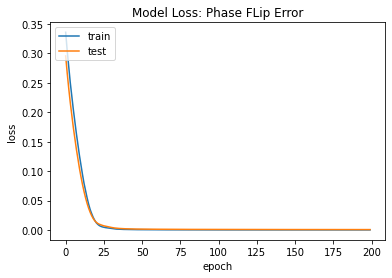

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>INF - 10 samples</font>

In [45]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:10], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:10], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [46]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [47]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity1)

In [48]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.7890 - val_loss: 0.5864
Epoch 2/200
1/1 [==============================] - 0s 43ms/step - loss: 0.7043 - val_loss: 0.5392
Epoch 3/200
1/1 [==============================] - 0s 48ms/step - loss: 0.6133 - val_loss: 0.4965
Epoch 4/200
1/1 [==============================] - 0s 43ms/step - loss: 0.5320 - val_loss: 0.4597
Epoch 5/200
1/1 [==============================] - 0s 47ms/step - loss: 0.4669 - val_loss: 0.4284
Epoch 6/200
1/1 [==============================] - 0s 42ms/step - loss: 0.4168 - val_loss: 0.4015
Epoch 7/200
1/1 [==============================] - 0s 47ms/step - loss: 0.3783 - val_loss: 0.3775
Epoch 8/200
1/1 [==============================] - 0s 46ms/step - loss: 0.3478 - val_loss: 0.3554
Epoch 9/200
1/1 [==============================] - 0s 45ms/step - loss: 0.3219 - val_loss: 0.3344
Epoch 10/200
1/1 [==============================] - 0s 46ms/step - loss: 0.2986 - val_loss: 0.3142
Epoch 11/200
1/1 [===

Epoch 84/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0060 - val_loss: 0.0216
Epoch 85/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0057 - val_loss: 0.0213
Epoch 86/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0054 - val_loss: 0.0210
Epoch 87/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0052 - val_loss: 0.0206
Epoch 88/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0049 - val_loss: 0.0203
Epoch 89/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0046 - val_loss: 0.0200
Epoch 90/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0044 - val_loss: 0.0196
Epoch 91/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0041 - val_loss: 0.0193
Epoch 92/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0039 - val_loss: 0.0189
Epoch 93/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0037 - val_loss: 0.0186
Epoch 94/2

1/1 [==============================] - 0s 43ms/step - loss: 1.2877e-04 - val_loss: 0.0127
Epoch 165/200
1/1 [==============================] - 0s 40ms/step - loss: 1.2444e-04 - val_loss: 0.0127
Epoch 166/200
1/1 [==============================] - 0s 44ms/step - loss: 1.2019e-04 - val_loss: 0.0126
Epoch 167/200
1/1 [==============================] - 0s 41ms/step - loss: 1.1608e-04 - val_loss: 0.0126
Epoch 168/200
1/1 [==============================] - 0s 39ms/step - loss: 1.1210e-04 - val_loss: 0.0126
Epoch 169/200
1/1 [==============================] - 0s 42ms/step - loss: 1.0825e-04 - val_loss: 0.0126
Epoch 170/200
1/1 [==============================] - 0s 39ms/step - loss: 1.0450e-04 - val_loss: 0.0126
Epoch 171/200
1/1 [==============================] - 0s 41ms/step - loss: 1.0088e-04 - val_loss: 0.0126
Epoch 172/200
1/1 [==============================] - 0s 43ms/step - loss: 9.7388e-05 - val_loss: 0.0126
Epoch 173/200
1/1 [==============================] - 0s 41ms/step - loss: 9.40

In [49]:
score = model.evaluate(x_test,  y_test, verbose=2)

1/1 - 0s - loss: 0.0097 - 140ms/epoch - 140ms/step


In [50]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  #infid=infidelity(y_test[i], y_prediction[i])
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

inf10_c = tf.math.reduce_mean(fidelities)
inf10 = tf.cast(inf10_c, tf.float64)
print(inf10)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.9903234809549433, shape=(), dtype=float64)


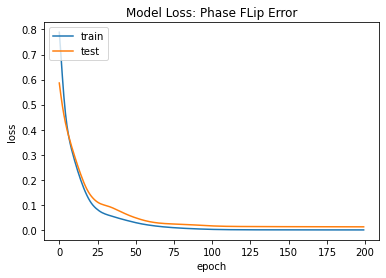

In [51]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>INF - 5 samples</font>

In [52]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:5], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:5], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [53]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [54]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity1)

In [55]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 927ms/step - loss: 0.3373 - val_loss: 0.4781
Epoch 2/200
1/1 [==============================] - 0s 52ms/step - loss: 0.2515 - val_loss: 0.4329
Epoch 3/200
1/1 [==============================] - 0s 46ms/step - loss: 0.1840 - val_loss: 0.3965
Epoch 4/200
1/1 [==============================] - 0s 47ms/step - loss: 0.1308 - val_loss: 0.3669
Epoch 5/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0895 - val_loss: 0.3419
Epoch 6/200
1/1 [==============================] - 0s 45ms/step - loss: 0.0593 - val_loss: 0.3237
Epoch 7/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0389 - val_loss: 0.3138
Epoch 8/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0253 - val_loss: 0.3086
Epoch 9/200
1/1 [==============================] - 0s 45ms/step - loss: 0.0168 - val_loss: 0.3059
Epoch 10/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0120 - val_loss: 0.3048
Epoch 11/200
1/1 [

1/1 [==============================] - 0s 43ms/step - loss: 8.2850e-06 - val_loss: 0.2558
Epoch 83/200
1/1 [==============================] - 0s 43ms/step - loss: 5.9605e-06 - val_loss: 0.2558
Epoch 84/200
1/1 [==============================] - 0s 40ms/step - loss: 4.2915e-06 - val_loss: 0.2559
Epoch 85/200
1/1 [==============================] - 0s 40ms/step - loss: 3.0994e-06 - val_loss: 0.2559
Epoch 86/200
1/1 [==============================] - 0s 46ms/step - loss: 2.3246e-06 - val_loss: 0.2559
Epoch 87/200
1/1 [==============================] - 0s 47ms/step - loss: 1.9550e-06 - val_loss: 0.2558
Epoch 88/200
1/1 [==============================] - 0s 39ms/step - loss: 1.8835e-06 - val_loss: 0.2558
Epoch 89/200
1/1 [==============================] - 0s 40ms/step - loss: 2.1338e-06 - val_loss: 0.2558
Epoch 90/200
1/1 [==============================] - 0s 41ms/step - loss: 2.5988e-06 - val_loss: 0.2558
Epoch 91/200
1/1 [==============================] - 0s 40ms/step - loss: 3.0398e-06 - 

1/1 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - val_loss: 0.2554
Epoch 162/200
1/1 [==============================] - 0s 42ms/step - loss: 3.5763e-08 - val_loss: 0.2554
Epoch 163/200
1/1 [==============================] - 0s 44ms/step - loss: 4.7684e-08 - val_loss: 0.2554
Epoch 164/200
1/1 [==============================] - 0s 41ms/step - loss: 3.5763e-08 - val_loss: 0.2554
Epoch 165/200
1/1 [==============================] - 0s 44ms/step - loss: -1.1921e-08 - val_loss: 0.2554
Epoch 166/200
1/1 [==============================] - 0s 41ms/step - loss: 1.1921e-08 - val_loss: 0.2554
Epoch 167/200
1/1 [==============================] - 0s 42ms/step - loss: -2.3842e-08 - val_loss: 0.2554
Epoch 168/200
1/1 [==============================] - 0s 40ms/step - loss: 1.1921e-08 - val_loss: 0.2554
Epoch 169/200
1/1 [==============================] - 0s 41ms/step - loss: 1.1921e-08 - val_loss: 0.2554
Epoch 170/200
1/1 [==============================] - 0s 46ms/step - loss: 2.

In [56]:
score = model.evaluate(x_test,  y_test, verbose=2)

1/1 - 0s - loss: 0.1805 - 122ms/epoch - 122ms/step


In [57]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  
  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)


inf5_c = tf.math.reduce_mean(fidelities)
inf5 = tf.cast(inf5_c, tf.float64)
print(inf5)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.8195133903428484, shape=(), dtype=float64)


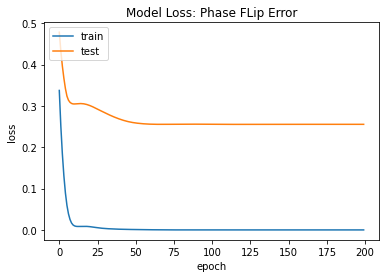

In [58]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>INF - 20 samples</font>

In [59]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:20], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:20], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [60]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [61]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity1)

In [62]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 170ms/step - loss: 0.4063 - val_loss: 0.3875
Epoch 2/200
2/2 [==============================] - 0s 53ms/step - loss: 0.2797 - val_loss: 0.3141
Epoch 3/200
2/2 [==============================] - 0s 45ms/step - loss: 0.1756 - val_loss: 0.2234
Epoch 4/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0974 - val_loss: 0.1016
Epoch 5/200
2/2 [==============================] - 0s 44ms/step - loss: 0.0449 - val_loss: 0.0654
Epoch 6/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0271 - val_loss: 0.0576
Epoch 7/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0219 - val_loss: 0.0499
Epoch 8/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0186 - val_loss: 0.0404
Epoch 9/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0134 - val_loss: 0.0316
Epoch 10/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0100 - val_loss: 0.0237
Epoch 11/200
2/2 [

2/2 [==============================] - 0s 40ms/step - loss: 2.6089e-05 - val_loss: 0.0056
Epoch 82/200
2/2 [==============================] - 0s 39ms/step - loss: 2.5213e-05 - val_loss: 0.0056
Epoch 83/200
2/2 [==============================] - 0s 39ms/step - loss: 2.4456e-05 - val_loss: 0.0056
Epoch 84/200
2/2 [==============================] - 0s 39ms/step - loss: 2.3228e-05 - val_loss: 0.0056
Epoch 85/200
2/2 [==============================] - 0s 38ms/step - loss: 2.2027e-05 - val_loss: 0.0056
Epoch 86/200
2/2 [==============================] - 0s 41ms/step - loss: 2.1681e-05 - val_loss: 0.0056
Epoch 87/200
2/2 [==============================] - 0s 42ms/step - loss: 2.0617e-05 - val_loss: 0.0056
Epoch 88/200
2/2 [==============================] - 0s 38ms/step - loss: 1.9658e-05 - val_loss: 0.0055
Epoch 89/200
2/2 [==============================] - 0s 39ms/step - loss: 1.8954e-05 - val_loss: 0.0055
Epoch 90/200
2/2 [==============================] - 0s 40ms/step - loss: 1.8451e-05 - 

2/2 [==============================] - 0s 42ms/step - loss: 2.0176e-06 - val_loss: 0.0053
Epoch 161/200
2/2 [==============================] - 0s 40ms/step - loss: 1.9461e-06 - val_loss: 0.0053
Epoch 162/200
2/2 [==============================] - 0s 41ms/step - loss: 1.9401e-06 - val_loss: 0.0053
Epoch 163/200
2/2 [==============================] - 0s 37ms/step - loss: 1.7613e-06 - val_loss: 0.0053
Epoch 164/200
2/2 [==============================] - 0s 39ms/step - loss: 1.8001e-06 - val_loss: 0.0053
Epoch 165/200
2/2 [==============================] - 0s 41ms/step - loss: 1.7971e-06 - val_loss: 0.0053
Epoch 166/200
2/2 [==============================] - 0s 37ms/step - loss: 1.6063e-06 - val_loss: 0.0052
Epoch 167/200
2/2 [==============================] - 0s 41ms/step - loss: 1.6391e-06 - val_loss: 0.0052
Epoch 168/200
2/2 [==============================] - 0s 37ms/step - loss: 1.4782e-06 - val_loss: 0.0052
Epoch 169/200
2/2 [==============================] - 0s 42ms/step - loss: 1.47

In [63]:
score = model.evaluate(x_test,  y_test, verbose=2)

1/1 - 0s - loss: 0.0039 - 120ms/epoch - 120ms/step


In [64]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)


inf20_c = tf.math.reduce_mean(fidelities)
inf20 = tf.cast(inf20_c, tf.float64)
print(inf20)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.9960504530055954, shape=(), dtype=float64)


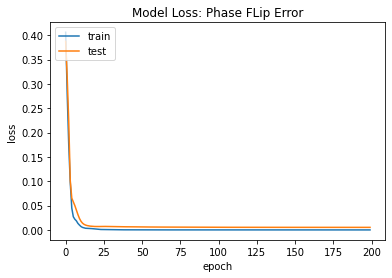

In [65]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>INF - 30 samples</font>

In [66]:
#Building the training, validation and test set 

x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:30], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:30], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)
print("Input data type:", x_train.dtype)
print("Output data type:", y_train.dtype)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

Input data type: <dtype: 'float64'>
Output data type: <dtype: 'float64'>


In [67]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [68]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity1)

In [69]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
3/3 [==============================] - 1s 87ms/step - loss: 0.2506 - val_loss: 0.2032
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 0.1306 - val_loss: 0.1198
Epoch 3/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0675 - val_loss: 0.0576
Epoch 4/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0262 - val_loss: 0.0344
Epoch 5/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0192 - val_loss: 0.0287
Epoch 6/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0175 - val_loss: 0.0205
Epoch 7/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0122 - val_loss: 0.0128
Epoch 8/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0067 - val_loss: 0.0097
Epoch 9/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0053 - val_loss: 0.0090
Epoch 10/200
3/3 [==============================] - 0s 21ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 11/200
3/3 [=

3/3 [==============================] - 0s 23ms/step - loss: 1.9598e-05 - val_loss: 0.0015
Epoch 82/200
3/3 [==============================] - 0s 21ms/step - loss: 1.9062e-05 - val_loss: 0.0015
Epoch 83/200
3/3 [==============================] - 0s 22ms/step - loss: 1.7669e-05 - val_loss: 0.0015
Epoch 84/200
3/3 [==============================] - 0s 21ms/step - loss: 1.6403e-05 - val_loss: 0.0015
Epoch 85/200
3/3 [==============================] - 0s 21ms/step - loss: 1.6030e-05 - val_loss: 0.0015
Epoch 86/200
3/3 [==============================] - 0s 21ms/step - loss: 1.5241e-05 - val_loss: 0.0015
Epoch 87/200
3/3 [==============================] - 0s 19ms/step - loss: 1.4361e-05 - val_loss: 0.0015
Epoch 88/200
3/3 [==============================] - 0s 20ms/step - loss: 1.3846e-05 - val_loss: 0.0015
Epoch 89/200
3/3 [==============================] - 0s 21ms/step - loss: 1.3224e-05 - val_loss: 0.0015
Epoch 90/200
3/3 [==============================] - 0s 20ms/step - loss: 1.2503e-05 - 

3/3 [==============================] - 0s 21ms/step - loss: 1.2438e-06 - val_loss: 0.0014
Epoch 161/200
3/3 [==============================] - 0s 21ms/step - loss: 1.2358e-06 - val_loss: 0.0014
Epoch 162/200
3/3 [==============================] - 0s 22ms/step - loss: 1.1841e-06 - val_loss: 0.0014
Epoch 163/200
3/3 [==============================] - 0s 22ms/step - loss: 1.2120e-06 - val_loss: 0.0014
Epoch 164/200
3/3 [==============================] - 0s 21ms/step - loss: 1.1245e-06 - val_loss: 0.0014
Epoch 165/200
3/3 [==============================] - 0s 21ms/step - loss: 1.0649e-06 - val_loss: 0.0014
Epoch 166/200
3/3 [==============================] - 0s 22ms/step - loss: 1.0967e-06 - val_loss: 0.0014
Epoch 167/200
3/3 [==============================] - 0s 20ms/step - loss: 1.0351e-06 - val_loss: 0.0014
Epoch 168/200
3/3 [==============================] - 0s 22ms/step - loss: 1.1961e-06 - val_loss: 0.0014
Epoch 169/200
3/3 [==============================] - 0s 20ms/step - loss: 9.97

In [70]:
score = model.evaluate(x_test,  y_test, verbose=2)

1/1 - 0s - loss: 6.5522e-04 - 122ms/epoch - 122ms/step


In [71]:
#save the model predictions in a tensor
y_prediction = model(x_test)
print("Bloch vector predicted type:", y_prediction.dtype)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
print("NEW Bloch vector predicted type:", y_prediction.dtype)

#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)
print("NEW output type:", y_test.dtype)

fidelities = []
infidelities = []
for i in range(len(y_prediction)):
  den_mat = density_matrix_from_bloch_vector(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = density_matrix_from_bloch_vector(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)


inf30_c = tf.math.reduce_mean(fidelities)
inf30 = tf.cast(inf30_c, tf.float64)

print(inf30)

Bloch vector predicted type: <dtype: 'float32'>
NEW Bloch vector predicted type: <dtype: 'complex128'>
NEW output type: <dtype: 'complex128'>
tf.Tensor(0.999344799553427, shape=(), dtype=float64)


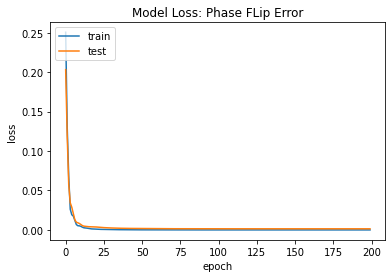

In [72]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='purple'>Plotting the Results</font>

In [95]:
x = np.array([5, 10, 20, 30])
y = np.array([fid5, fid10, fid20, fid30])
z = np.array([inf5, inf10, inf20, inf30])

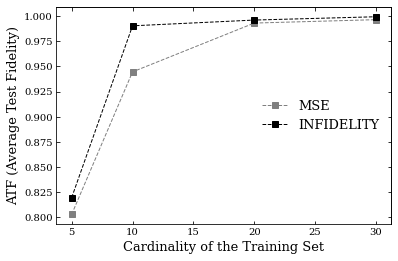

In [163]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

plt.figure(figsize = (6,4))
plt.plot(x, y, label='MSE', color='0.50', ls='dashed', marker='s', linewidth=1)
plt.plot(x, z, label='INFIDELITY', color='k', ls='dashed', marker='s', linewidth=1)
ax = plt.subplot()

plt.xlabel("Cardinality of the Training Set", fontsize=13) 
plt.ylabel("ATF (Average Test Fidelity)", fontsize=13)
leg = plt.legend(fontsize=13, loc='center right', frameon='False')

secax = ax.secondary_xaxis('top')
secay = ax.secondary_yaxis('right')
ax.tick_params(axis="both", direction='in')
secax.tick_params(axis="x", direction="in")
secay.tick_params(axis="y", direction="in")
secax.set_xticklabels([])
secay.set_yticklabels([])


leg.get_frame().set_linewidth(0.0)

plt.savefig("md_oq.png")